<a href="https://colab.research.google.com/github/SomaOkuda/Tweet-Analysis/blob/main/emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymlask
!pip install janome
#MeCabインストール
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.996.3
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a
!pip install emoji
!pip install japanize-matplotlib
!pip install gensim==3.4.0
!pip install smart_open==1.9.0
!pip install WordCroud
!apt-get -y install fonts-ipafont-gothic

     |████████████████████████████████| 70 kB 5.1 MB/s 
  Created wheel for pymlask: filename=pymlask-0.3.2-py3-none-any.whl size=74906 sha256=758f69fe8c9f319708f982596974a5bb07a88c2b09e3c50ab3007c8d82358962
  Stored in directory: /root/.cache/pip/wheels/28/a8/2b/a4e4b83dc2ee2d492f49a8ad59325fff4d3540254a5a4ac560
Successfully built pymlask
     |████████████████████████████████| 19.7 MB 13.0 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
  swig3.0
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-inde

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import smart_open
import gensim
from gensim.models import word2vec
import glob
import pickle
import emoji
import csv
import re
from mlask import MLAsk
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import math
from wordcloud import WordCloud

emotion_analyzer = MLAsk()

import MeCab
tagger=MeCab.Tagger('-Owakati')

from janome.tokenizer import Tokenizer
import time
# Tokenizerインスタンスの生成 
t = Tokenizer()

In [ ]:
csv_files = glob.glob('/content/drive/My Drive/Tweet/tweet/auto_test/*.csv') #jpサンプルツイートフォルダ内結合
data_list = []
for file in csv_files:
  data_list.append(pd.read_csv(file, lineterminator='\n'))  
df = pd.concat(data_list, axis=0, sort=False)
df = df.drop_duplicates(keep='last') #重複の削除、列の最後の方が時刻が遅いため、lastで指定
df=df.reset_index(drop=True)

elim=[]
for i in range(len(df)):
  if str(df.iloc[i]['text']).startswith('RT') is True:
    elim.append(i)

#RT除去
df1=df.drop(elim)
df1=df1.reset_index(drop=True)
len(df)

362651

In [ ]:
elim_http=[]
for j in range(len(df1)):
  user_text=df1.iloc[j]['text']
  word_list=list(tagger.parse(user_text).split())
  if 'https' in word_list:
    elim_http.append(j)
  elif 'http' in word_list:
    elim_http.append(j)
  elif '@' in word_list:
    elim_http.append(j)

#http除去
df2=df1.drop(elim_http)
df2=df2.reset_index(drop=True)
len(df2) 

37236

In [ ]:
emotion_list = []
orientation_list = []

for k in range(len(df2)):
  text = df2.iloc[k]['text']
  result = emotion_analyzer.analyze(text)
  try:
    orientation = result['orientation']
    kanjo = result['representative']
    emotion_list.append(kanjo)
    orientation_list.append(orientation)
  except KeyError:
    kanjo = 'NA'
    orientation = 'NA'
    emotion_list.append(kanjo)
    orientation_list.append(orientation)
len(emotion_list)

37236

In [ ]:
df2["orientation"] = orientation_list
df2["emotion"] = emotion_list

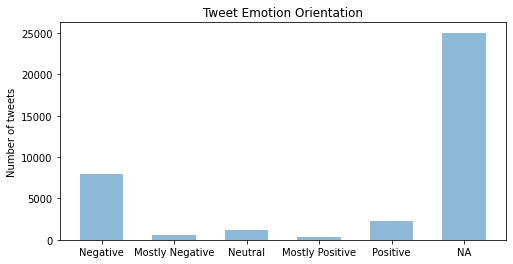

In [ ]:
orientation_negative = (df2['orientation'] == 'NEGATIVE')
orientation_positive = (df2['orientation'] == 'POSITIVE')
orientation_neutral = (df2['orientation'] == 'NEUTRAL')
orientation_mone = (df2['orientation'] == 'mostly_NEGATIVE')
orientation_mopo = (df2['orientation'] == 'mostly_POSITIVE')
orientation_na = (df2['orientation'] == 'NA')
#RTやhttpを除くツイートの感情(positive vs. negative)の図示
objects_orientation = ('Negative', 'Mostly Negative', 'Neutral' ,'Mostly Positive', 'Positive', 'NA')
y_pos = np.arange(len(objects_orientation))
performance = [orientation_negative.sum(), orientation_mone.sum(), orientation_neutral.sum(), orientation_mopo.sum(), orientation_positive.sum(), orientation_na.sum()]
plt.figure(figsize=(8,4))
plt.bar(y_pos, performance, align='center', alpha=0.5, width=0.6)
plt.xticks(y_pos, objects_orientation)
plt.ylabel('Number of tweets')
plt.title('Tweet Emotion Orientation')

plt.show()

In [ ]:
#Russelの感情円環に基づいて10感情が分類される
#喜, 怒, 哀, 怖, 恥, 好, 厭, 昂, 安, 驚
objects_emotion = ('joy', 'anger', 'sorrow', 'fear', 'shame', 'liking', 'dislike', 'excitement', 'relief', 'surprise', 'NA')
df3 = df2['emotion']
df4 = []
for i in range(len(df3)):
  row = str(df3[i])
  df4.append(row)

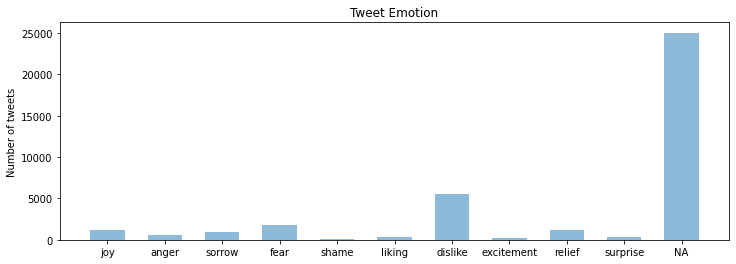

In [ ]:
emotion_yorokobi = [s for s in df4 if 'yorokobi' in s]
emotion_ikari = [s for s in df4 if 'ikari' in s]
emotion_aware = [s for s in df4 if 'aware' in s]
emotion_kowagari = [s for s in df4 if 'kowa' in s]
emotion_haji = [s for s in df4 if 'haji' in s]
emotion_suki = [s for s in df4 if 'suki' in s]
emotion_iya = [s for s in df4 if 'iya' in s]
emotion_takaburi = [s for s in df4 if 'takaburi' in s]
emotion_yasuragi = [s for s in df4 if 'yasu' in s]
emotion_odoroki = [s for s in df4 if 'odoroki' in s]
emotion_na = [s for s in df4 if 'NA' in s]

y_pos = np.arange(len(objects_emotion))
performance = [len(emotion_yorokobi), len(emotion_ikari), len(emotion_aware), len(emotion_kowagari), len(emotion_haji), len(emotion_suki), len(emotion_iya), len(emotion_takaburi), len(emotion_yasuragi), len(emotion_odoroki), len(emotion_na)]
plt.figure(figsize=(12,4))
plt.bar(y_pos, performance, align='center', alpha=0.5, width=0.6)
plt.xticks(y_pos, objects_emotion)
plt.ylabel('Number of tweets')
plt.title('Tweet Emotion')

plt.show()

感情とRT数の分析。cytoscapeで抽出したRT数（degree.layout）と感情の関係を調べる

In [ ]:
#感情とRT数
#ネットワークdegree.laをすることにより、リンクの数がわかる。このリンクの数と感情の関係を示す（今後はfollowerも必要）
df99 = pd.read_csv("/content/drive/My Drive/Tweet/RT_Emotion/220110_vactine_propagation_RT_dgt2.gml default node.csv")

In [ ]:
df99 = df99.fillna(0)

In [ ]:
#リンク数が少ないものを除去する（多くの人に共有されるツイートはどういうツイートが多いのか？）
elim99=[]
for i in range(len(df99)):
  if df99["degree.layout"][i] < 30.0: #50以上のRTがあるオリジナルツイートのみを摘出
    elim99.append(i)

df100=df99.drop(elim99)
df100=df100.reset_index(drop=True)
len(df100)

938

In [ ]:
emo_rt = []
for j in range(len(df100)):
  for k in range(len(df2)):
    if df100["name"][j] == df2["user_name"][k]:
      emo = str(df2["emotion"][k])
      newline = [df100["degree.layout"][j], df2["orientation"][k], emo, df100["cluster"][j], df2["follower"][k]]
      emo_rt.append(newline)

In [ ]:
emo_rt = pd.DataFrame(emo_rt, columns=["degree.layout", "orientation", "emotion", "cluster", "follower"])

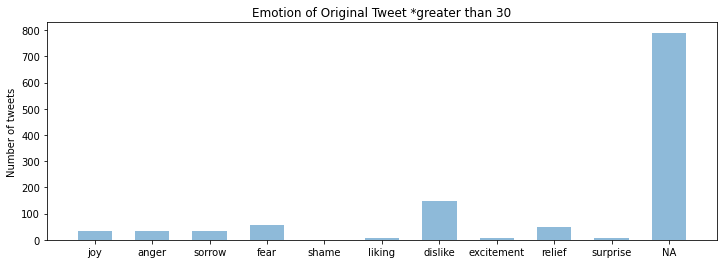

In [ ]:
emotion_yorokobi_gt50 = [s for s in emo_rt["emotion"] if 'yorokobi' in s]
emotion_ikari_gt50 = [s for s in emo_rt["emotion"] if 'ikari' in s]
emotion_aware_gt50 = [s for s in emo_rt["emotion"] if 'aware' in s]
emotion_kowagari_gt50 = [s for s in emo_rt["emotion"] if 'kowa' in s]
emotion_haji_gt50 = [s for s in emo_rt["emotion"] if 'haji' in s]
emotion_suki_gt50 = [s for s in emo_rt["emotion"] if 'suki' in s]
emotion_iya_gt50 = [s for s in emo_rt["emotion"] if 'iya' in s]
emotion_takaburi_gt50 = [s for s in emo_rt["emotion"] if 'takaburi' in s]
emotion_yasuragi_gt50 = [s for s in emo_rt["emotion"] if 'yasu' in s]
emotion_odoroki_gt50 = [s for s in emo_rt["emotion"] if 'odoroki' in s]
emotion_na_gt50 = [s for s in emo_rt["emotion"] if 'NA' in s]

y_pos = np.arange(len(objects_emotion))
performance_emo_gt50 = [len(emotion_yorokobi_gt50), len(emotion_ikari_gt50), len(emotion_aware_gt50), len(emotion_kowagari_gt50), len(emotion_haji_gt50), len(emotion_suki_gt50), len(emotion_iya_gt50), len(emotion_takaburi_gt50), len(emotion_yasuragi_gt50), len(emotion_odoroki_gt50), len(emotion_na_gt50)]
plt.figure(figsize=(12,4))
plt.bar(y_pos, performance_emo_gt50, align='center', alpha=0.5, width=0.6)
plt.xticks(y_pos, objects_emotion)
plt.ylabel('Number of tweets')
plt.title('Emotion of Original Tweet *greater than 30')

plt.show()

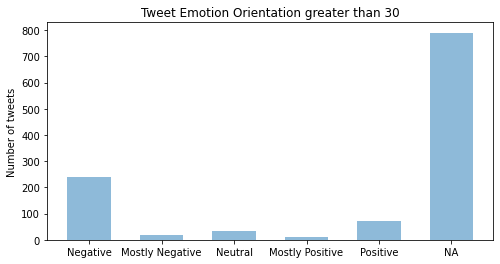

In [ ]:
orientation_negative_gt50 = (emo_rt["orientation"] == 'NEGATIVE')
orientation_positive_gt50 = (emo_rt["orientation"] == 'POSITIVE')
orientation_neutral_gt50 = (emo_rt["orientation"] == 'NEUTRAL')
orientation_mone_gt50 = (emo_rt["orientation"] == 'mostly_NEGATIVE')
orientation_mopo_gt50 = (emo_rt["orientation"] == 'mostly_POSITIVE')
orientation_na_gt50 = (emo_rt["orientation"] == 'NA')
objects_orientation = ('Negative', 'Mostly Negative', 'Neutral' ,'Mostly Positive', 'Positive', 'NA')
y_pos = np.arange(len(objects_orientation))
performance_ori_gt50 = [orientation_negative_gt50.sum(), orientation_mone_gt50.sum(), orientation_neutral_gt50.sum(), orientation_mopo_gt50.sum(), orientation_positive_gt50.sum(), orientation_na_gt50.sum()]
plt.figure(figsize=(8,4))
plt.bar(y_pos, performance_ori_gt50, align='center', alpha=0.5, width=0.6)
plt.xticks(y_pos, objects_orientation)
plt.ylabel('Number of tweets')
plt.title('Tweet Emotion Orientation greater than 30')

plt.show()

Text(0.5, 1.0, 'ReTweet Number and followers *greater than 30')

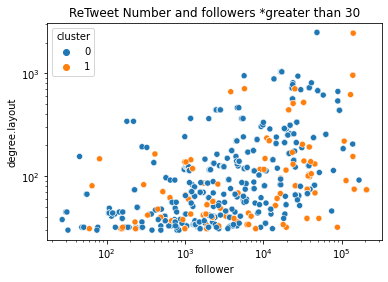

In [ ]:
sns.scatterplot(x="follower", y="degree.layout", data=emo_rt, ci=95, hue="cluster")
plt.xscale('log')
plt.yscale('log')
#plt.xlabel('followers')
#plt.ylabel('Number of Retweets')
plt.title('ReTweet Number and followers *greater than 30')

Text(0.5, 1.0, 'ReTweet Number and followers *greater than 30')

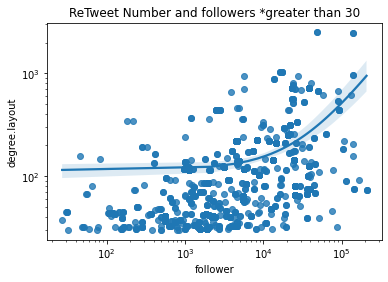

In [ ]:
sns.regplot(x="follower", y="degree.layout", data=emo_rt, ci=95, fit_reg=True)
plt.xscale('log')
plt.yscale('log')
plt.title('ReTweet Number and followers *greater than 30')

In [ ]:
x = emo_rt["follower"]
y = emo_rt["degree.layout"]
coef1 = np.corrcoef(x, y)
#coef2 = np.corrcoef(math.log10(x), math.log10(y))
print(coef1)

[[1.         0.36694923]
 [0.36694923 1.        ]]


[6325.0, 7215.0, 7078.0, 9803.0, 0, 1258.0, 19332.0, 1685.0, 5516.0, 975.0, 136023.0]


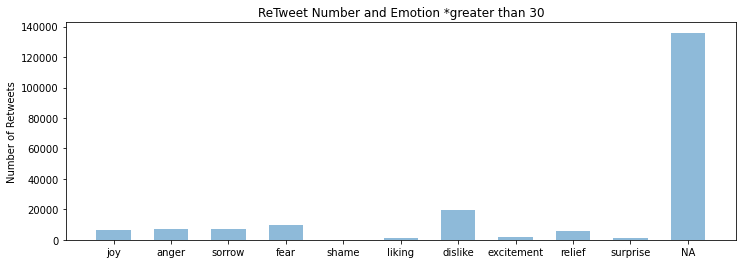

In [ ]:
num_yorokobi_gt50 = 0
num_ikari_gt50 = 0
num_aware_gt50 = 0
num_kowagari_gt50 = 0
num_haji_gt50 = 0
num_suki_gt50 = 0
num_iya_gt50 = 0
num_takaburi_gt50 = 0
num_yasuragi_gt50 = 0
num_odoroki_gt50 = 0
num_NA_gt50 = 0

for s in range(len(emo_rt)):
  if 'yorokobi' in emo_rt["emotion"][s]:
    num_yorokobi_gt50 = num_yorokobi_gt50 + emo_rt["degree.layout"][s]
  elif 'ikari' in emo_rt["emotion"][s]:
    num_ikari_gt50 = num_ikari_gt50 + emo_rt["degree.layout"][s]
  elif 'aware' in emo_rt["emotion"][s]:
    num_aware_gt50 =  num_aware_gt50 + emo_rt["degree.layout"][s]
  elif 'kowa' in emo_rt["emotion"][s]:
    num_kowagari_gt50 = num_kowagari_gt50 + emo_rt["degree.layout"][s]
  elif 'haji' in emo_rt["emotion"][s]:
    num_haji_gt50 = num_haji_gt50 + emo_rt["degree.layout"][s]
  elif 'suki' in emo_rt["emotion"][s]:
    num_suki_gt50 = num_suki_gt50 + emo_rt["degree.layout"][s]
  elif 'iya' in emo_rt["emotion"][s]:
    num_iya_gt50 = num_iya_gt50 + emo_rt["degree.layout"][s]
  elif 'takaburi' in emo_rt["emotion"][s]:
    num_takaburi_gt50 = num_takaburi_gt50 + emo_rt["degree.layout"][s]
  elif 'yasu' in emo_rt["emotion"][s]:
    num_yasuragi_gt50 = num_yasuragi_gt50 + emo_rt["degree.layout"][s]
  elif 'odoroki' in emo_rt["emotion"][s]:
    num_odoroki_gt50 = num_odoroki_gt50 + emo_rt["degree.layout"][s]
  elif 'NA' in emo_rt["emotion"][s]:
    num_NA_gt50 = num_NA_gt50 + emo_rt["degree.layout"][s]

y_pos = np.arange(len(objects_emotion))
performance_gt50_num = [num_yorokobi_gt50, num_ikari_gt50, num_aware_gt50, num_kowagari_gt50, num_haji_gt50, num_suki_gt50, num_iya_gt50, num_takaburi_gt50, num_yasuragi_gt50, num_odoroki_gt50, num_NA_gt50]
plt.figure(figsize=(12,4))
plt.bar(y_pos, performance_gt50_num, align='center', alpha=0.5, width=0.6)
plt.xticks(y_pos, objects_emotion)
plt.ylabel('Number of Retweets')
plt.title('ReTweet Number and Emotion *greater than 30')
print(performance_gt50_num)

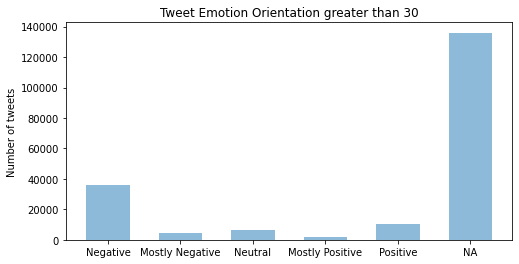

In [ ]:
num_n_gt50 = 0
num_mn_gt50 = 0
num_nu_gt50 = 0
num_mp_gt50 = 0
num_p_gt50 = 0
num_na_gt50 = 0

for s in range(len(emo_rt)):
  if 'NEGATIVE' == emo_rt["orientation"][s]:
    num_n_gt50 = num_n_gt50 + emo_rt["degree.layout"][s]
  elif 'mostly_NEGATIVE' == emo_rt["orientation"][s]:
    num_mn_gt50 = num_mn_gt50 + emo_rt["degree.layout"][s]
  elif 'NEUTRAL' in emo_rt["orientation"][s]:
    num_nu_gt50 =  num_nu_gt50 + emo_rt["degree.layout"][s]
  elif 'mostly_POSITIVE' == emo_rt["orientation"][s]:
    num_mp_gt50 = num_mp_gt50 + emo_rt["degree.layout"][s]
  elif 'POSITIVE' == emo_rt["orientation"][s]:
    num_p_gt50 = num_p_gt50 + emo_rt["degree.layout"][s]
  elif 'NA' == emo_rt["orientation"][s]:
    num_na_gt50 = num_na_gt50 + emo_rt["degree.layout"][s]

y_pos = np.arange(len(objects_orientation))
performance_ori_gt50 = [num_n_gt50, num_mn_gt50, num_nu_gt50, num_mp_gt50, num_p_gt50, num_na_gt50]
plt.figure(figsize=(8,4))
plt.bar(y_pos, performance_ori_gt50, align='center', alpha=0.5, width=0.6)
plt.xticks(y_pos, objects_orientation)
plt.ylabel('Number of tweets')
plt.title('Tweet Emotion Orientation greater than 30')

plt.show()

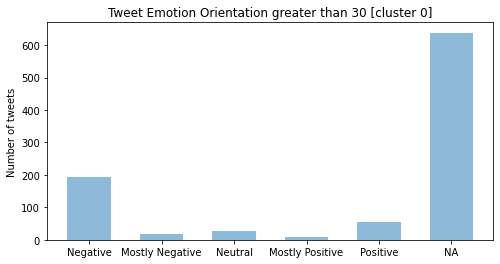

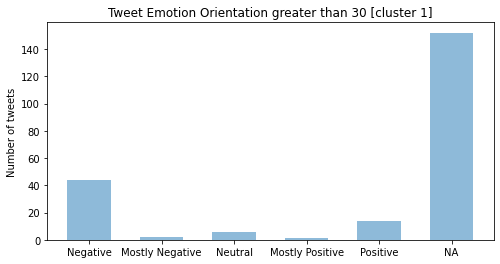

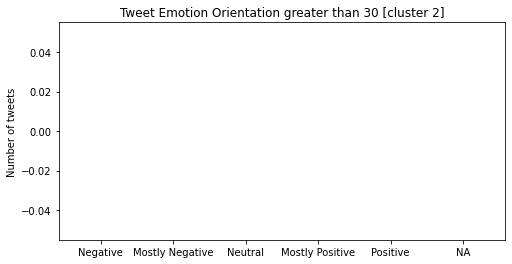

In [ ]:
orientation_negative_gt50_cl0 = ('NEGATIVE' == emo_rt["orientation"]) & (emo_rt["cluster"] == 0)
orientation_positive_gt50_cl0 = (('POSITIVE' == emo_rt["orientation"]) & (emo_rt["cluster"] == 0))
orientation_neutral_gt50_cl0 = (('NEUTRAL' == emo_rt["orientation"]) & (emo_rt["cluster"] == 0))
orientation_mone_gt50_cl0 = (('mostly_NEGATIVE' == emo_rt["orientation"]) & (emo_rt["cluster"] == 0))
orientation_mopo_gt50_cl0 = (('mostly_POSITIVE' == emo_rt["orientation"]) & (emo_rt["cluster"] == 0))
orientation_na_gt50_cl0 = (('NA' == emo_rt["orientation"]) & (emo_rt["cluster"] == 0))
orientation_negative_gt50_cl1 = ('NEGATIVE' == emo_rt["orientation"]) & (emo_rt["cluster"] == 1)
orientation_positive_gt50_cl1 = (('POSITIVE' == emo_rt["orientation"]) & (emo_rt["cluster"] == 1))
orientation_neutral_gt50_cl1 = (('NEUTRAL' == emo_rt["orientation"]) & (emo_rt["cluster"] == 1))
orientation_mone_gt50_cl1 = (('mostly_NEGATIVE' == emo_rt["orientation"]) & (emo_rt["cluster"] == 1))
orientation_mopo_gt50_cl1 = (('mostly_POSITIVE' == emo_rt["orientation"]) & (emo_rt["cluster"] == 1))
orientation_na_gt50_cl1 = (('NA' == emo_rt["orientation"]) & (emo_rt["cluster"] == 1))
orientation_negative_gt50_cl2 = ('NEGATIVE' == emo_rt["orientation"]) & (emo_rt["cluster"] == 18)
orientation_positive_gt50_cl2 = (('POSITIVE' == emo_rt["orientation"]) & (emo_rt["cluster"] == 18))
orientation_neutral_gt50_cl2 = (('NEUTRAL' == emo_rt["orientation"]) & (emo_rt["cluster"] == 18))
orientation_mone_gt50_cl2 = (('mostly_NEGATIVE' == emo_rt["orientation"]) & (emo_rt["cluster"] == 18))
orientation_mopo_gt50_cl2 = (('mostly_POSITIVE' == emo_rt["orientation"]) & (emo_rt["cluster"] == 18))
orientation_na_gt50_cl2 = (('NA' == emo_rt["orientation"]) & (emo_rt["cluster"] == 18))

objects_orientation = ('Negative', 'Mostly Negative', 'Neutral' ,'Mostly Positive', 'Positive', 'NA')

y_pos = np.arange(len(objects_orientation))
#num_ori_gt50_cl0 = [num_n_gt50_cl0, num_mn_gt50_cl0, num_nu_gt50_cl0, num_mp_gt50_cl0, num_p_gt50_cl0, num_na_gt50_cl0]
performance_ori_gt50_cl0 = [orientation_negative_gt50_cl0.sum(), orientation_mone_gt50_cl0.sum(), orientation_neutral_gt50_cl0.sum(), orientation_mopo_gt50_cl0.sum(), orientation_positive_gt50_cl0.sum(), orientation_na_gt50_cl0.sum()]
performance_ori_gt50_cl1 = [orientation_negative_gt50_cl1.sum(), orientation_mone_gt50_cl1.sum(), orientation_neutral_gt50_cl1.sum(), orientation_mopo_gt50_cl1.sum(), orientation_positive_gt50_cl1.sum(), orientation_na_gt50_cl1.sum()]
performance_ori_gt50_cl2 = [orientation_negative_gt50_cl2.sum(), orientation_mone_gt50_cl2.sum(), orientation_neutral_gt50_cl2.sum(), orientation_mopo_gt50_cl2.sum(), orientation_positive_gt50_cl2.sum(), orientation_na_gt50_cl2.sum()]

plt.figure(figsize=(8,4))
plt.bar(y_pos, performance_ori_gt50_cl0, align='center', alpha=0.5, width=0.6)
plt.xticks(y_pos, objects_orientation)
plt.ylabel('Number of tweets')
plt.title('Tweet Emotion Orientation greater than 30 [cluster 0]')

plt.figure(figsize=(8,4))
plt.bar(y_pos, performance_ori_gt50_cl1, align='center', alpha=0.5, width=0.6)
plt.xticks(y_pos, objects_orientation)
plt.ylabel('Number of tweets')
plt.title('Tweet Emotion Orientation greater than 30 [cluster 1]')

plt.figure(figsize=(8,4))
plt.bar(y_pos, performance_ori_gt50_cl2, align='center', alpha=0.5, width=0.6)
plt.xticks(y_pos, objects_orientation)
plt.ylabel('Number of tweets')
plt.title('Tweet Emotion Orientation greater than 30 [cluster 2]')

plt.show()

In [ ]:
num_n_gt50_cl0 = 0
num_mn_gt50_cl0 = 0
num_nu_gt50_cl0 = 0
num_mp_gt50_cl0 = 0
num_p_gt50_cl0 = 0
num_na_gt50_cl0 = 0

objects_orientation = ('Negative', 'Mostly Negative', 'Neutral' ,'Mostly Positive', 'Positive', 'NA')
for s in range(len(emo_rt)):
  if ('NEGATIVE' == emo_rt[1][s]) and (emo_rt[3][s] == 0):
    num_n_gt50_cl0 = num_n_gt50_cl0 + emo_rt[0][s]
    orientation_negative_gt50_cl0.append(emo_rt[s])
  elif ('mostly_NEGATIVE' == emo_rt[1][s]) and (emo_rt[3][s] == 0):
    num_mn_gt50_cl0 = num_mn_gt50_cl0 + emo_rt[0][s]
    orientation_mone_gt50_cl0.append(emo_rt[s])
  elif ('NEUTRAL' == emo_rt[1][s]) and (emo_rt[3][s] == 0):
    num_nu_gt50_cl0 =  num_nu_gt50_cl0 + emo_rt[0][s]
    orientation_neutral_gt50_cl0.append(emo_rt[s])
  elif ('mostly_POSITIVE' == emo_rt[1][s]) and (emo_rt[3][s] == 0):
    num_mp_gt50_cl0 = num_mp_gt50_cl0 + emo_rt[0][s]
    orientation_mopo_gt50_cl0.append(emo_rt[s])
  elif ('POSITIVE' == emo_rt[1][s]) and (emo_rt[3][s] == 0):
    num_p_gt50_cl0 = num_p_gt50_cl0 + emo_rt[0][s]
    orientation_positive_gt50_cl0.append(emo_rt[s])
  elif ('NA' == emo_rt[1][s]) and (emo_rt[3][s] == 0):
    num_na_gt50_cl0 = num_na_gt50_cl0 + emo_rt[0][s]
    orientation_na_gt50_cl0.append(emo_rt[s])

記事の準備

In [ ]:
https = []
for q in range(len(df1)):
  if q in elim_http:
    l = df1.loc[q,:]
    https.append(l)

In [ ]:
https = pd.DataFrame(https, columns = ["id", "user_name", "time", "text", "place", "favo", "RT", "follower"])
https =https.reset_index(drop=True)

In [ ]:
http_list = []
for r in range(len(https)):
  myString = https["text"][r]
  myString_list = [item for item in myString.split(" ")]
  for item in myString_list:
    try:
      match = re.search("(?P<url>https?://[^\s]+)", myString)
      if match is not None: 
        urls = match.group("url")
        http_list.append(urls)
    except:
      pass

In [ ]:
http_data = pd.DataFrame(http_list)
http_data_dudel = http_data.drop_duplicates(keep = 'last')
http_data_dudel = http_data_dudel.reset_index(drop=True)
#http_list = set(http_list) #最初に回す場合
##一度回してから
droped_url = []
http_get = []
csv_files_http = glob.glob("/content/drive/My Drive/Tweet/headline/*.csv")
for headfile in csv_files_http:
  http_get.append(pd.read_csv(headfile, lineterminator='\n'))
http_get = pd.concat(http_get, axis=0, sort=False)
http_get = http_get.drop_duplicates()
http_get=http_get.reset_index(drop=True)
http_dudel_list = http_data_dudel[0].values.tolist()
http_get = http_get["URL"].values.tolist()

In [ ]:
for i in range(len(http_dudel_list)):
  if http_dudel_list[i] not in http_get:
    droped_url.append(http_dudel_list[i])
http_list = droped_url
print(len(http_list))

4174


In [ ]:
title_list = []
with open('/content/drive/My Drive/Tweet/headline/210111_vactine_article_3.csv', 'w',newline='',encoding='utf-8') as f: #change number if runtime error happens
  writer = csv.writer(f, lineterminator='\n')
  writer.writerow(["URL", "Headline"])
  for url in http_list:
      try:
          r = requests.get(url, timeout=3)
          soup = BeautifulSoup(r.content, "html.parser")
          html_element = soup.find("h1")
          article_title = html_element.text.strip()
          line = [url, article_title]
          title_list.append(line)
          writer.writerow(line)
      except Exception as e:
          pass  # ignore any pages where there is a problem

In [ ]:
#全URL取得後ここから実行
http_get = []
csv_http = glob.glob("/content/drive/My Drive/Tweet/headline/*.csv")
for headfile in csv_http:
  http_get.append(pd.read_csv(headfile, lineterminator='\n'))
http_get = pd.concat(http_get, axis=0, sort=False)
http_get = http_get.drop_duplicates()
http_get=http_get.reset_index(drop=True)

In [ ]:
drop_java_na = []
for i in range(len(http_get)):
  if "JavaScript is not available." in str(http_get.iloc[i]["Headline"]):
    drop_java_na.append(i)
  elif '404' in str(http_get.iloc[i]["Headline"]):
    drop_java_na.append(i)
  elif 'お探しの情報は' in str(http_get.iloc[i]["Headline"]):
    drop_java_na.append(i)
  elif 'お探しのページが見つかりませんでした' in str(http_get.iloc[i]["Headline"]):
    drop_java_na.append(i)
  elif 'ページが見つかりませんでした' in str(http_get.iloc[i]["Headline"]):
    drop_java_na.append(i)
  elif 'Nothing to see here' in str(http_get.iloc[i]["Headline"]):
    drop_java_na.append(i)
  elif http_get.iloc[i]["Headline"] == Null:
    drop_java_na.append(i)
  elif '403' in str(http_get.iloc[i]["Headline"]):
    drop_java_na.append(i)
  elif 'Forbidden' in str(http_get.iloc[i]["Headline"]):
    drop_java_na.append(i)
  #yahoo news, ニコニコ動画, 質問箱などのサイト名がh1にあるケースも削除する
  elif 'Yahoo!ニュース' in str(http_get.iloc[i]["Headline"]):
    drop_java_na.append(i)
  elif 'ニコニコ動画' in str(http_get.iloc[i]["Headline"]):
    drop_java_na.append(i)
  elif 'Peing' in str(http_get.iloc[i]["Headline"]):
    drop_java_na.append(i)
  elif 'Not Found' in str(http_get.iloc[i]["Headline"]):
    drop_java_na.append(i)
  elif 'FC2動画' in str(http_get.iloc[i]["Headline"]):
    drop_java_na.append(i)
  elif 'Bloomberg' in str(http_get.iloc[i]["Headline"]):
    drop_java_na.append(i)
  elif '国際ニュース：AFPBB News' in str(http_get.iloc[i]["Headline"]):
    drop_java_na.append(i)
  elif 'Service Unavailable' in str(http_get.iloc[i]["Headline"]):
    drop_java_na.append(i)
  elif '調布経済新聞' in str(http_get.iloc[i]["Headline"]):
    drop_java_na.append(i)
  elif '共同通信' in str(http_get.iloc[i]["Headline"]):
    drop_java_na.append(i)
  elif 'SBS 뉴스' in str(http_get.iloc[i]["Headline"]):
    drop_java_na.append(i)
  elif '福島民友' in str(http_get.iloc[i]["Headline"]):
    drop_java_na.append(i)
  elif 'ESPN' in str(http_get.iloc[i]["Headline"]):
    drop_java_na.append(i)

In [ ]:
http_available = http_get.drop(drop_java_na)
http_available = http_available.dropna()
http_available = http_available.reset_index(drop=True)
http_available.to_csv("/content/drive/My Drive/Tweet/headline/220117_available_test.csv")

頻出単語の分析

In [ ]:
def Remove_word(list):
  rems = ['@', ',', '，', '。', '', ' ', 'http', 'https','//', '、', '×', '.',
            '+', '＋', '/',', ', '(', ')', '（', '）', '://', 'RT', ':', ';','：', '；',
            '」','「', '＠', '-', '／',  '%', '％', '!', '！', '#', '＃',
            '$', '＄', '=', '＝', 'ー', '￥', '^', '{', '}', '~', '～', 
            '&', '＆', '・', '?', '??', '？', '？？',  '<', '＜', '>', '＞', '_', '＿', 
            'co', 'jp', '(@', '○', '『', '』', '”', '’', '"', '…', '‼', '(+'
            ')」', '〇', '【', '】', '[', ']', '⁉', 'gt',
            'から', 'より', 'こそ', 'でも', 'しか','さえ', 'けれど', 'たり', 'つつ', 'とも',
            'たら', 'ある', 'なら', 'のに', 'です', 'ます', 'する', 'ほど', 'ない', 'くる',
            'なり', 'そう', 'まし', 'その', 'この', 'あの', 'せる', 'どう', 'ため', 'どこ',
            'いる', 'これ', 'それ', 'あれ', 'いい', 'など', 'あっ', 'もう', 'さん', 'じゃ',
            'から', 'あり', 'ので', 'とも', 'ませ', 'でし', 'とき', 'こと', 'なる', 'って',
            'ただ', 'まで', 'もの', 'つか', 'なっ', 'でき', 'もっ', 'けど', 'ほぼ', 'なー',
            'そこ', 'ここ', 'だろ', 'なん', 'だっ', 'なあ', 'っけ', 'せる', 'やっ', 'また',
            'どれ', 'なれ', 'かも', 'いく', 'いけ', 'いう', 'たい', 'あと', 'かも', 'しれ',  
            'こう', 'なく', 'よく', 'だけ', 'れる', 'よう', 'かけ', 'どの', 'てる', 'とか',
            'という', '思う', '思っ', 'として', 'ところ', 'しまう', 'なんか', 'そんな', 
            'でしょ', 'しまい', 'わかり', 'まま'
            '\u200d', '\u3000#'
            ]
  for number in range(10000):
    rems.append(str(number))

# 一文字のひらがなとカタカナ，全角数字，アルファベット大文字・小文字
  hirakana    = [chr(i) for i in range(12353, 12436)]
  katakana    = [chr(i) for i in range(12449, 12533)]
  zenkaku_num = [chr(i) for i in range(65296, 65296+10)]
  alph_L      = [chr(i) for i in range(97, 97+26)]
  alph_S      = [chr(i) for i in range(65, 65+26)]

  for a in range(len(hirakana)):
    rems.append(hirakana[a])
  for b in range(len(katakana)):
    rems.append(katakana[b])
  for c in range(len(zenkaku_num)):
    rems.append(zenkaku_num[c])
  for d in range(len(alph_L)):
    rems.append(alph_L[d])
  for e in range(len(alph_S)):
    rems.append(alph_S[e])

  words = [x for x in list if (x not in rems)]
  return words

In [ ]:
def extract_word(text):
    tokens = t.tokenize(text)
    return [token.base_form for token in tokens 
        if token.part_of_speech.split(',')[0] in['名詞', '動詞','形容詞']]

all_users_words=[]

for i in range(len(http_available)):
  user_text=http_available.iloc[i]['Headline']
  #text=list(tagger.parse(user_text).split())
  words=extract_word(user_text)
  all_users_words.append(words)
  
all_users_words1=[e for inner_list in all_users_words for e in inner_list]
import pickle
f = open('/content/drive/My Drive/Tweet/w2b/220117_vaccine.txt', 'wb')
list_row = all_users_words1
pickle.dump(list_row, f)

In [ ]:
word_chain = ' '.join(list_row)
stop_words = [u'くる', u'する', u'なる', u'ない', u'こと', u'れる', u'せる', u'of', u'the', u'いる', u'さん', u'in', u'to', u'できる']
wordcloud = WordCloud(background_color="white", font_path = '/usr/share/fonts/truetype/fonts-japanese-mincho.ttf', collocations = False, stopwords = set(stop_words), width=600,height=400,min_font_size=15)
wordcloud.generate(word_chain)
wordcloud.to_file("/content/drive/My Drive/Tweet/figures/220117_article_wordcloud.png")

記事の感情分析

In [ ]:
emotion_article_list = []
orientation_article_list = []

for k in range(len(http_available)):
  headline = http_available.iloc[k]['Headline']
  result_headline = emotion_analyzer.analyze(headline)
  try:
    orientation_headline = result_headline['orientation']
    kanjo_headline = result_headline['representative']
    emotion_article_list.append(kanjo_headline)
    orientation_article_list.append(orientation_headline)
  except KeyError:
    kanjo_headline = 'NA'
    orientation_headline = 'NA'
    emotion_article_list.append(kanjo_headline)
    orientation_article_list.append(orientation_headline)

6550

In [ ]:
headline_emotion = http_available
headline_emotion["orientation"] = orientation_article_list
headline_emotion["emotion"] = emotion_article_list

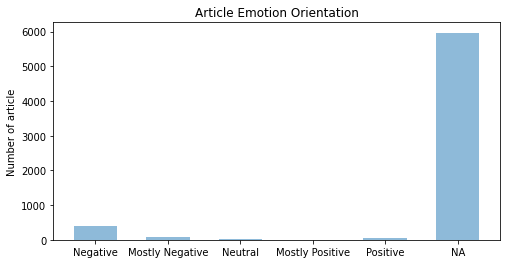

In [ ]:
orientation_article_negative = (headline_emotion['orientation'] == 'NEGATIVE')
orientation_article_positive = (headline_emotion['orientation'] == 'POSITIVE')
orientation_article_neutral = (headline_emotion['orientation'] == 'NEUTRAL')
orientation_article_mone = (headline_emotion['orientation'] == 'mostly_NEGATIVE')
orientation_article_mopo = (headline_emotion['orientation'] == 'mostly_POSITIVE')
orientation_article_na = (headline_emotion['orientation'] == 'NA')
#RTやhttpを除くツイートの感情(positive vs. negative)の図示
objects_orientation = ('Negative', 'Mostly Negative', 'Neutral' ,'Mostly Positive', 'Positive', 'NA')
import matplotlib.pyplot as plt
y_pos = np.arange(len(objects_orientation))
performance = [orientation_article_negative.sum(), orientation_article_mone.sum(), orientation_article_neutral.sum(), orientation_article_mopo.sum(), orientation_article_positive.sum(), orientation_article_na.sum()]
plt.figure(figsize=(8,4))
plt.bar(y_pos, performance, align='center', alpha=0.5, width=0.6)
plt.xticks(y_pos, objects_orientation)
plt.ylabel('Number of article')
plt.title('Article Emotion Orientation')

plt.show()

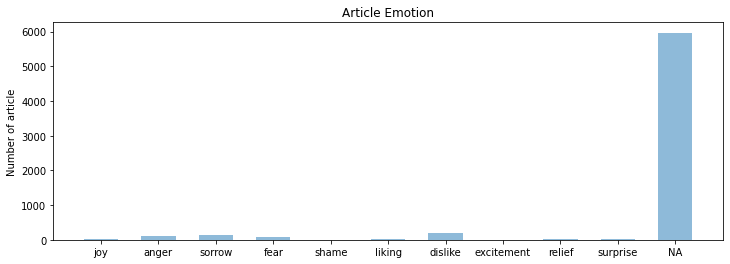

In [ ]:
emotion_article_yorokobi = [s for s in headline_emotion['emotion'] if 'yorokobi' in s]
emotion_article_ikari = [s for s in headline_emotion['emotion'] if 'ikari' in s]
emotion_article_aware = [s for s in headline_emotion['emotion'] if 'aware' in s]
emotion_article_kowagari = [s for s in headline_emotion['emotion'] if 'kowa' in s]
emotion_article_haji = [s for s in headline_emotion['emotion'] if 'haji' in s]
emotion_article_suki = [s for s in headline_emotion['emotion'] if 'suki' in s]
emotion_article_iya = [s for s in headline_emotion['emotion'] if 'iya' in s]
emotion_article_takaburi = [s for s in headline_emotion['emotion'] if 'takaburi' in s]
emotion_article_yasuragi = [s for s in headline_emotion['emotion'] if 'yasu' in s]
emotion_article_odoroki = [s for s in headline_emotion['emotion'] if 'odoroki' in s]
emotion_article_na = [s for s in headline_emotion['emotion'] if 'NA' in s]
objects_emotion = ('joy', 'anger', 'sorrow', 'fear', 'shame', 'liking', 'dislike', 'excitement', 'relief', 'surprise', 'NA')
y_pos = np.arange(len(objects_emotion))
performance = [len(emotion_article_yorokobi), len(emotion_article_ikari), len(emotion_article_aware), len(emotion_article_kowagari), len(emotion_article_haji), len(emotion_article_suki), len(emotion_article_iya), len(emotion_article_takaburi), len(emotion_article_yasuragi), len(emotion_article_odoroki), len(emotion_article_na)]
plt.figure(figsize=(12,4))
plt.bar(y_pos, performance, align='center', alpha=0.5, width=0.6)
plt.xticks(y_pos, objects_emotion)
plt.ylabel('Number of article')
plt.title('Article Emotion')

plt.show()